Mandatory packages to be imported

In [1]:
!pip install numpy
!pip install yfinance
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf

In [29]:
from pandas.tseries.offsets import DateOffset

Take in VIX data (1990 till date)

In [3]:
vix_df = yf.download('^VIX')

[*********************100%***********************]  1 of 1 completed


In [4]:
vix_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-01-02,17.240000,17.240000,17.240000,17.240000,17.240000,0
1990-01-03,18.190001,18.190001,18.190001,18.190001,18.190001,0
1990-01-04,19.219999,19.219999,19.219999,19.219999,19.219999,0
1990-01-05,20.110001,20.110001,20.110001,20.110001,20.110001,0
1990-01-08,20.260000,20.260000,20.260000,20.260000,20.260000,0
...,...,...,...,...,...,...
2022-05-23,28.980000,30.389999,28.290001,28.480000,28.480000,0
2022-05-24,29.430000,31.070000,29.040001,29.450001,29.450001,0
2022-05-25,29.330000,30.230000,28.160000,28.370001,28.370001,0


Strategy specification (1-month Moving Average)

In [5]:
vix_df['MA'] = vix_df.Close.rolling('30D').mean()

In [6]:
vix_df.head()

,Open,High,Low,Close,Adj Close,Volume,MA
Date,,,,,,,
1990-01-02,17.240000,17.240000,17.240000,17.240000,17.240000,0,17.240000
1990-01-03,18.190001,18.190001,18.190001,18.190001,18.190001,0,17.715000
1990-01-04,19.219999,19.219999,19.219999,19.219999,19.219999,0,18.216667
1990-01-05,20.110001,20.110001,20.110001,20.110001,20.110001,0,18.690000
1990-01-08,20.260000,20.260000,20.260000,20.260000,20.260000,0,19.004000


Comparing 'Close' and MA

In [7]:
vix_df_filtered = vix_df[vix_df.Close > 1.5 * vix_df.MA]

In [8]:
vix_df_filtered.head()

,Open,High,Low,Close,Adj Close,Volume,MA
Date,,,,,,,
1990-08-06,35.910000,35.910000,35.910000,35.910000,35.910000,0,20.330476
1990-08-07,32.750000,32.750000,32.750000,32.750000,32.750000,0,20.895000
1994-04-04,23.610001,28.299999,23.610001,23.870001,23.870001,0,15.487000
1997-10-30,36.709999,38.560001,35.840000,38.200001,38.200001,0,23.360909
2001-09-17,43.200001,44.330002,39.770000,41.759998,41.759998,0,25.810625


Further filter to pick values for timedelta > 30 days

In [9]:
pd.Series(vix_df_filtered.index)

0    1990-08-06
1    1990-08-07
2    1994-04-04
3    1997-10-30
4    2001-09-17
        ...    
60   2020-03-19
61   2021-01-27
62   2021-11-26
63   2021-12-01
64   2022-01-25
Name: Date, Length: 65, dtype: datetime64[ns]

In [10]:
pd.Series(vix_df_filtered.index).diff()

0          NaT
1       1 days
2    1336 days
3    1305 days
4    1418 days
        ...   
60      1 days
61    314 days
62    303 days
63      5 days
64     55 days
Name: Date, Length: 65, dtype: timedelta64[ns]

Convert to float

In [11]:
pd.Series(vix_df_filtered.index).diff() / np.timedelta64(1, 'D')

0        NaN
1        1.0
2     1336.0
3     1305.0
4     1418.0
       ...  
60       1.0
61     314.0
62     303.0
63       5.0
64      55.0
Name: Date, Length: 65, dtype: float64

Filter for 1 month

In [12]:
pd.Series(vix_df_filtered.index).diff() / np.timedelta64(1, 'D') >= 30

0     False
1     False
2      True
3      True
4      True
      ...  
60    False
61     True
62     True
63    False
64     True
Name: Date, Length: 65, dtype: bool

In [13]:
series = pd.Series(vix_df_filtered.index).diff() / np.timedelta64(1, 'D') >= 30

To get around initial value NaT

In [14]:
series[0] = True

In [15]:
series

0      True
1     False
2      True
3      True
4      True
      ...  
60    False
61     True
62     True
63    False
64     True
Name: Date, Length: 65, dtype: bool

Get buying signals

In [16]:
signals = vix_df_filtered[series.values]
signals.head()

,Open,High,Low,Close,Adj Close,Volume,MA
Date,,,,,,,
1990-08-06,35.910000,35.910000,35.910000,35.910000,35.910000,0,20.330476
1994-04-04,23.610001,28.299999,23.610001,23.870001,23.870001,0,15.487000
1997-10-30,36.709999,38.560001,35.840000,38.200001,38.200001,0,23.360909
2001-09-17,43.200001,44.330002,39.770000,41.759998,41.759998,0,25.810625
2007-02-27,12.120000,19.010000,12.100000,18.309999,18.309999,0,10.921905


This specific signal has been triggered 21 times since 1990

In [17]:
signals.shape

(21, 7)

In [18]:
sp500_df = yf.download('^GSPC', start = '1990-01-01')
sp500_df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-01-02,353.399994,359.690002,351.980011,359.690002,359.690002,162070000
1990-01-03,359.690002,360.589996,357.890015,358.760010,358.760010,192330000
1990-01-04,358.760010,358.760010,352.890015,355.670013,355.670013,177000000
1990-01-05,355.670013,355.670013,351.350006,352.200012,352.200012,158530000
1990-01-08,352.200012,354.239990,350.540009,353.790009,353.790009,140110000


In [27]:
signals.index[0]

Timestamp('1990-08-06 00:00:00')

In [30]:
signals.index[0] + DateOffset(months = 6)

Timestamp('1991-02-06 00:00:00')

In [31]:
test_ = sp500_df[(sp500_df.index >= signals.index[0]) & 
                 (sp500_df.index <= signals.index[0] + DateOffset(months = 6))]

In [32]:
test_

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-08-06,344.859985,344.859985,333.269989,334.429993,334.429993,240400000
1990-08-07,334.429993,338.630005,332.220001,334.829987,334.829987,231580000
1990-08-08,334.829987,339.209991,334.829987,338.350006,338.350006,190400000
1990-08-09,338.350006,340.559998,337.559998,339.940002,339.940002,155810000
1990-08-10,339.899994,339.899994,334.220001,335.519989,335.519989,145340000
...,...,...,...,...,...,...
1991-01-31,340.920013,343.929993,340.470001,343.929993,343.929993,204520000
1991-02-01,343.910004,344.899994,340.369995,343.049988,343.049988,246670000
1991-02-04,343.049988,348.709991,342.959991,348.339996,348.339996,250750000


In [35]:
(test_.Close.pct_change() + 1).cumprod()

Date
1990-08-06         NaN
1990-08-07    1.001196
1990-08-08    1.011721
1990-08-09    1.016476
1990-08-10    1.003259
                ...   
1991-01-31    1.028407
1991-02-01    1.025775
1991-02-04    1.041593
1991-02-05    1.050324
1991-02-06    1.070687
Name: Close, Length: 129, dtype: float64

In [40]:
returns = []

for i in range(len(signals)):
  sub_df = sp500_df[(sp500_df.index >= signals.index[i]) & 
                 (sp500_df.index <= signals.index[i] + DateOffset(months = 6))]
  
  returns.append((sub_df.Close.pct_change() + 1).prod())

In [43]:
final_ret = pd.Series(returns)

In [45]:
final_ret.mean()

1.0635252673727866

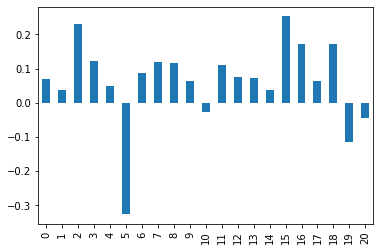

In [47]:
(final_ret - 1).plot(kind = 'bar')

A return of 6.3525%

---
fin